Convert Red Mask Images To Binary Images

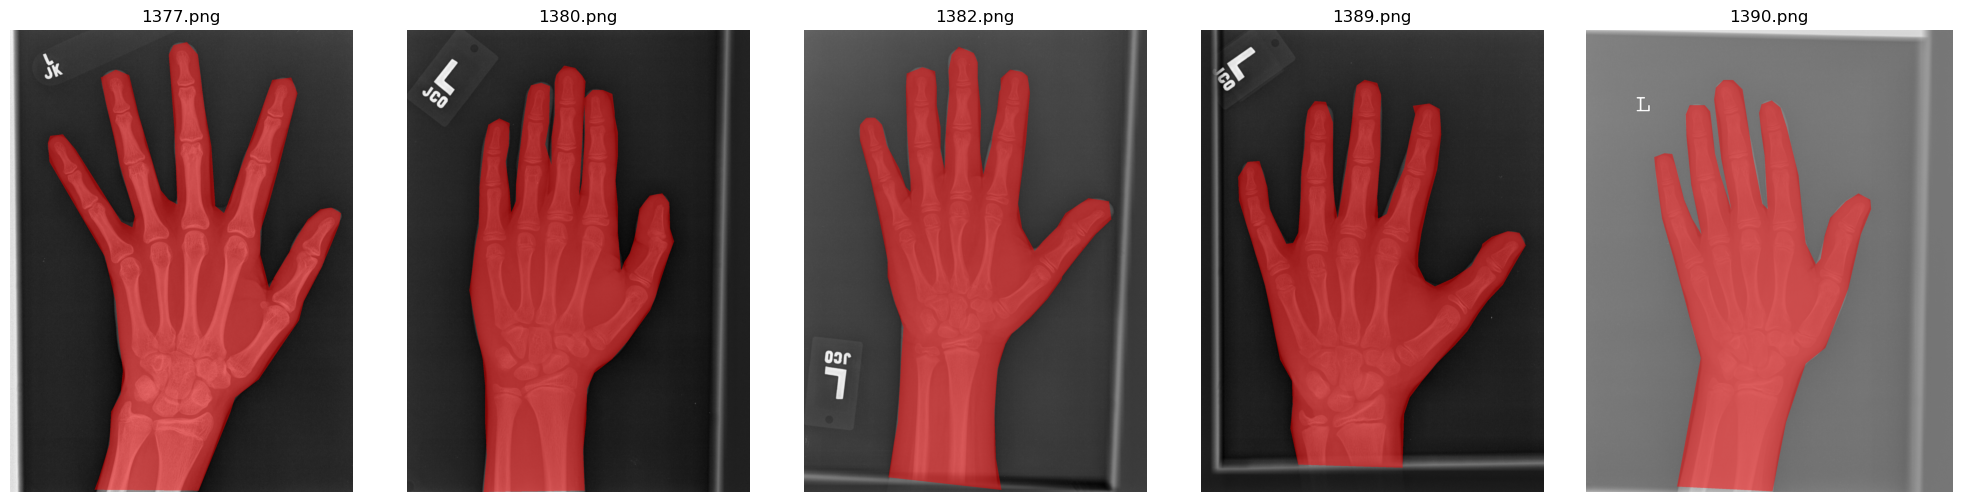

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display up to 5 images from a specific folder side by side
def display_images_from_folder(folder_path, max_images=5):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out image files (assuming they have typical image extensions)
    image_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp']
    image_files = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]
    
    # Limit the number of images to display
    image_files = image_files[:max_images]
    
    # Create a figure to display images
    num_images = len(image_files)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through image files and display each one
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        
        plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.title(image_file)  # Set the title of the subplot
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\final project KHCC\masks"
display_images_from_folder(folder_path, max_images=5)


In [ ]:
import cv2
import numpy as np
import os

def convert_to_binary(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add or remove file extensions as needed
            # Read the image
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)
            
            # Convert to HSV color space
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            
            # Define range for red color
            lower_red = np.array([0, 120, 70])
            upper_red = np.array([10, 255, 255])
            mask1 = cv2.inRange(hsv, lower_red, upper_red)
            
            lower_red = np.array([170, 120, 70])
            upper_red = np.array([180, 255, 255])
            mask2 = cv2.inRange(hsv, lower_red, upper_red)
            
            # Combine masks
            mask = mask1 + mask2
            
            # Create binary image (255 for mask, 0 for background)
            binary = np.zeros(img.shape[:2], dtype=np.uint8)
            binary[mask > 0] = 255
            
            # Save the result
            output_path = os.path.join(output_folder, f'binary_{filename}')
            cv2.imwrite(output_path, binary)
            
            print(f'Processed: {filename}')

# Usage
input_folder = 'path/to/input/folder'
output_folder = 'path/to/output/folder'
#convert_to_binary(input_folder, output_folder)

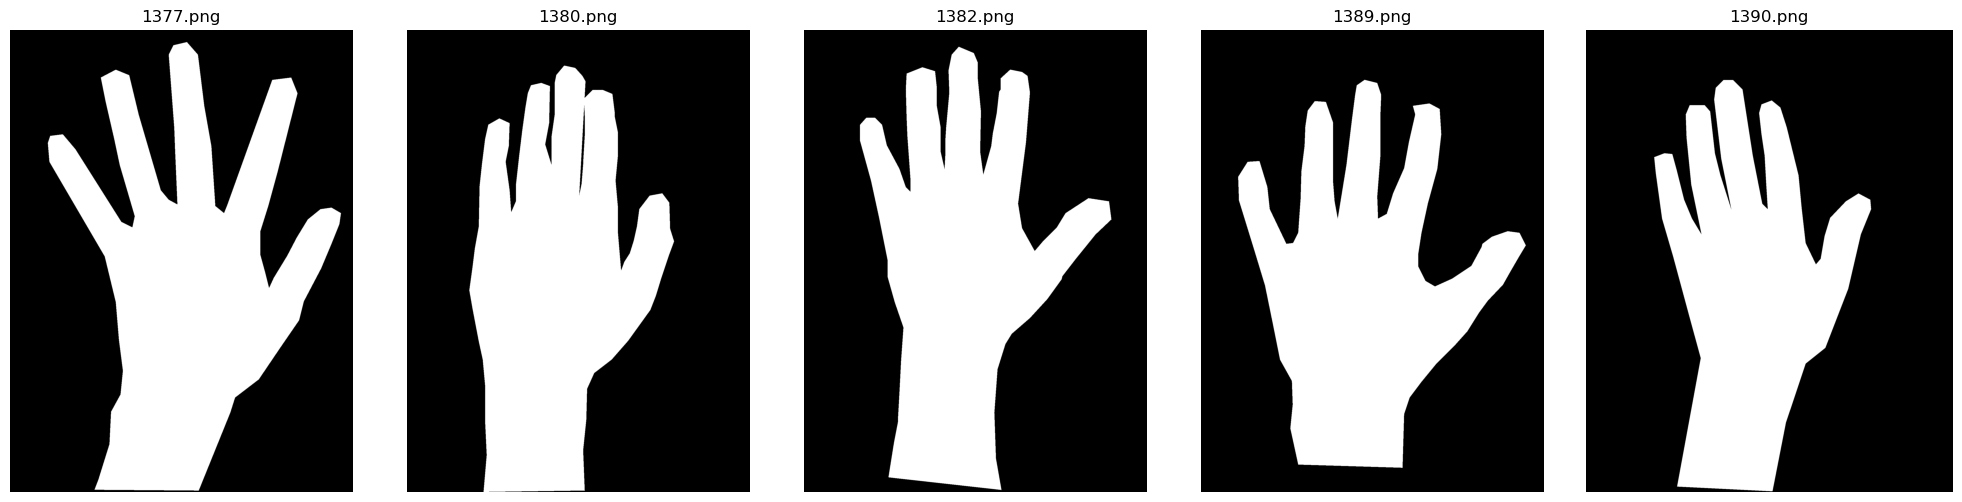

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\final project KHCC\masks binary"

# List of specific image filenames
image_names = ['1377.png', '1380.png', '1382.png', '1389.png', '1390.png']

display_specific_images_from_folder(folder_path, image_names)


Create A Model for Segmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define U-Net model
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder (Upsampling)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def extract_patches(image, mask, patch_size=128, stride=64):
    patches = []
    mask_patches = []
    h, w = image.shape[:2]
    
    for y in range(0, h-patch_size+1, stride):
        for x in range(0, w-patch_size+1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            mask_patches.append(mask_patch)
    
    return np.array(patches), np.array(mask_patches)

def load_and_patch_data(image_dir, mask_dir, patch_size=128, stride=96):
    all_patches = []
    all_mask_patches = []
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        patches, mask_patches = extract_patches(img, mask, patch_size, stride)
        
        all_patches.extend(patches)
        all_mask_patches.extend(mask_patches)
    
    return np.array(all_patches), np.array(all_mask_patches)

def augment_data(images, masks):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    
    img_gen = datagen.flow(images, batch_size=len(images), seed=42)
    mask_gen = datagen.flow(masks, batch_size=len(masks), seed=42)
    
    augmented_images = next(img_gen)
    augmented_masks = next(mask_gen)
    
    return np.concatenate([images, augmented_images]), np.concatenate([masks, augmented_masks])

def train_patch_unet():
    # Load and patch data
    patches, mask_patches = load_and_patch_data('path/to/image/dir', 'path/to/mask/dir')
    
    # Normalize
    patches = patches / 255.0
    mask_patches = mask_patches / 255.0
    
    # Augment data
    patches, mask_patches = augment_data(patches, mask_patches)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(patches, mask_patches, test_size=0.2, random_state=42)
    
    # Reshape for model input
    X_train = X_train.reshape((-1, 128, 128, 1))
    X_val = X_val.reshape((-1, 128, 128, 1))
    y_train = y_train.reshape((-1, 128, 128, 1))
    y_val = y_val.reshape((-1, 128, 128, 1))
    
    # Create and compile model
    model = unet_model(input_size=(128, 128, 1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
    
    return model

def predict_full_image(model, image, patch_size=128, stride=96):
    h, w = image.shape[:2]
    pred_mask = np.zeros((h, w))
    counts = np.zeros((h, w))
    
    for y in range(0, h-patch_size+1, stride):
        for x in range(0, w-patch_size+1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patch = patch.reshape((1, patch_size, patch_size, 1)) / 255.0
            pred = model.predict(patch)[0].reshape((patch_size, patch_size))
            
            pred_mask[y:y+patch_size, x:x+patch_size] += pred
            counts[y:y+patch_size, x:x+patch_size] += 1
    
    # Average overlapping predictions
    pred_mask = pred_mask / counts
    return pred_mask

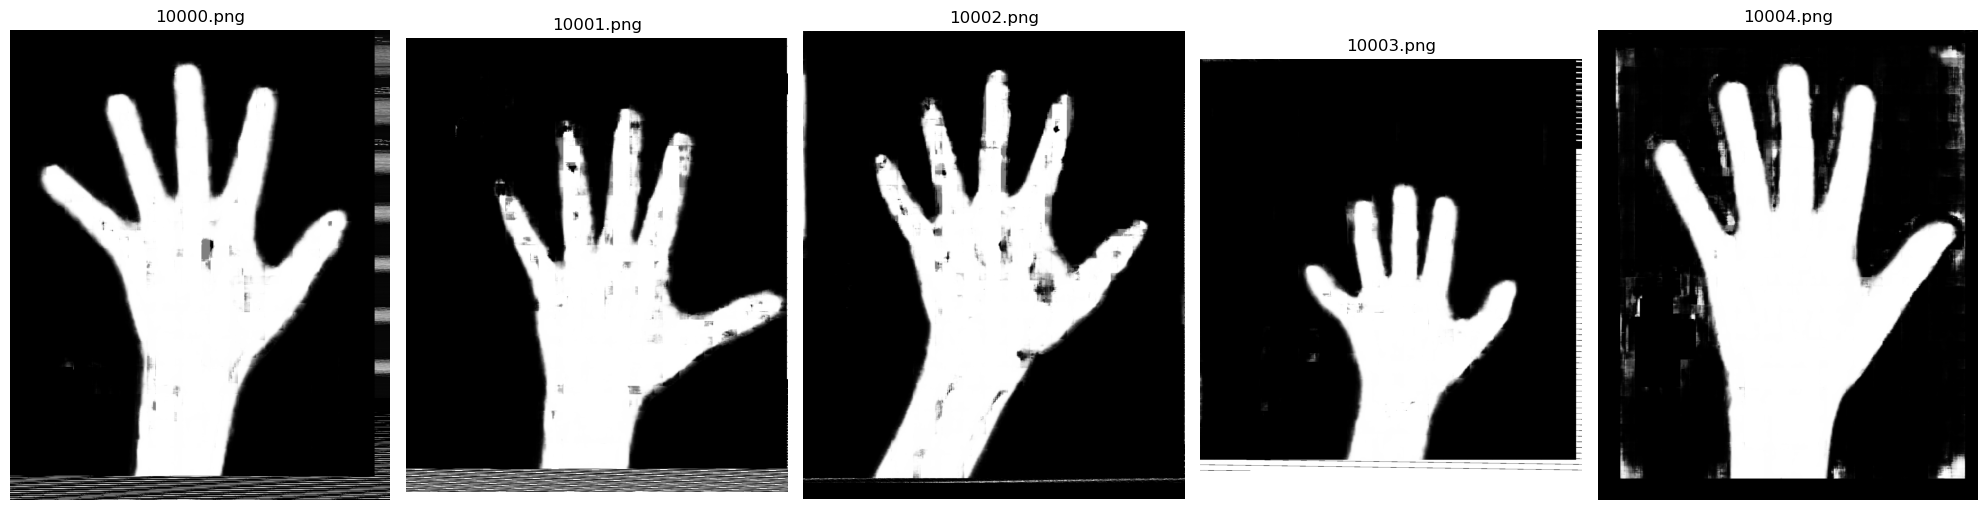

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display up to 5 grayscale images from a folder side by side
def display_grayscale_images_from_folder(folder_path, max_images=5):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out image files (assuming they have typical image extensions)
    image_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp']
    image_files = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]
    
    # Limit the number of images to display
    image_files = image_files[:max_images]
    
    # Create a figure to display images
    num_images = len(image_files)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through image files and display each one
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_file)  # Set the title of the subplot
        else:
            print(f"Image {image_file} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\final project KHCC\finally binary images"

display_grayscale_images_from_folder(folder_path)


Apply Contour to Images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to apply contours to an image and display the result
def apply_contours_to_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at path '{image_path}' could not be loaded.")
        return

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to the grayscale image
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the original image
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green contours with thickness 2

    # Convert the image from BGR to RGB (for displaying with matplotlib)
    contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
    
    # Display the image with contours
    plt.imshow(contour_image_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()


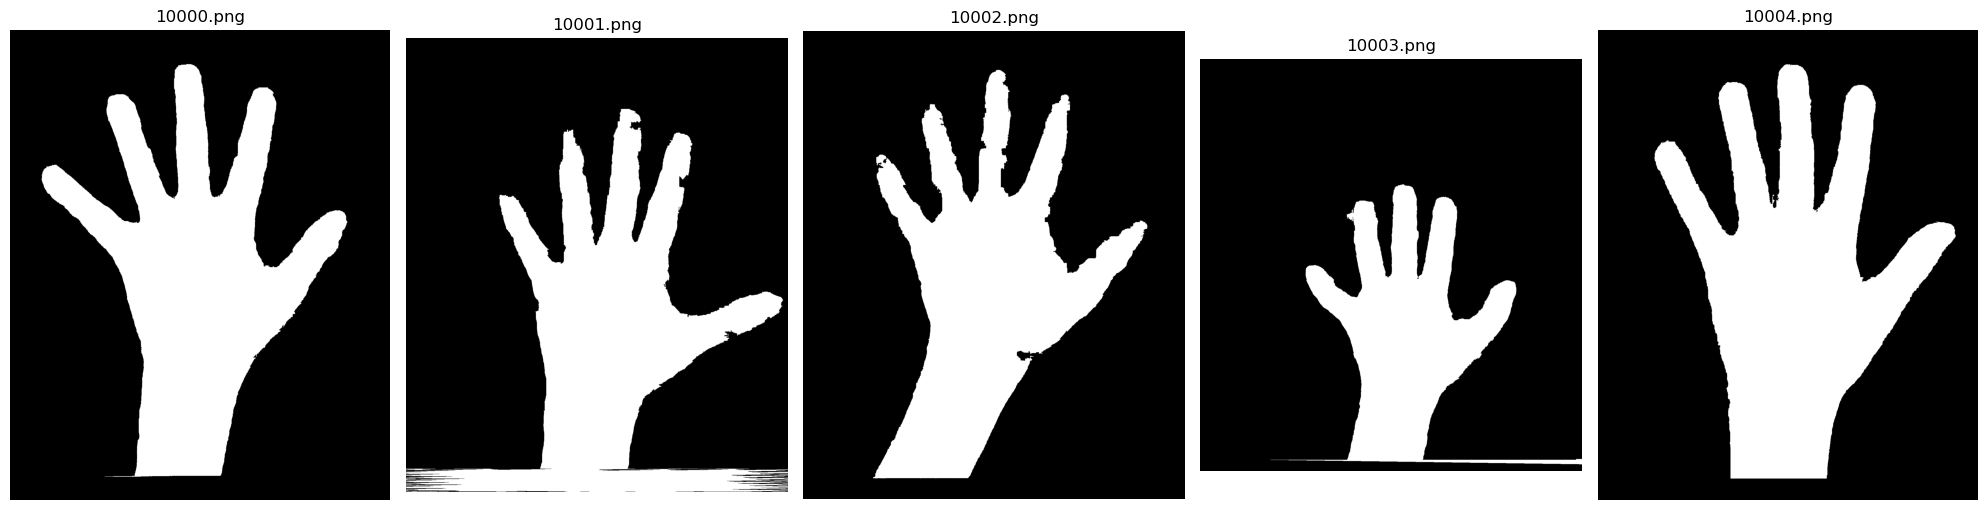

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\final project KHCC\finally binary images contours"

# List of specific image filenames
image_names = ['10000.png', '10001.png', '10002.png', '10003.png', '10004.png']

display_specific_images_from_folder(folder_path, image_names)


Apply Dilation to Images

In [ ]:
import cv2
import numpy as np
import os

# Function to apply dilation to images in a folder
def apply_dilation_to_images(folder_path, output_folder, kernel_size=(11, 11), iterations=1):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter out image files (assuming they have typical image extensions)
    image_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp']
    image_files = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]

    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Error: Image at path '{image_path}' could not be loaded.")
            continue

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply binary threshold to get a binary image
        _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

        # Define the structuring element for dilation
        kernel = np.ones(kernel_size, np.uint8)
        
        # Apply dilation
        dilated_image = cv2.dilate(binary_image, kernel, iterations=iterations)

        # Save the dilated image
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, dilated_image)

        print(f"Dilated image saved at: {output_path}")

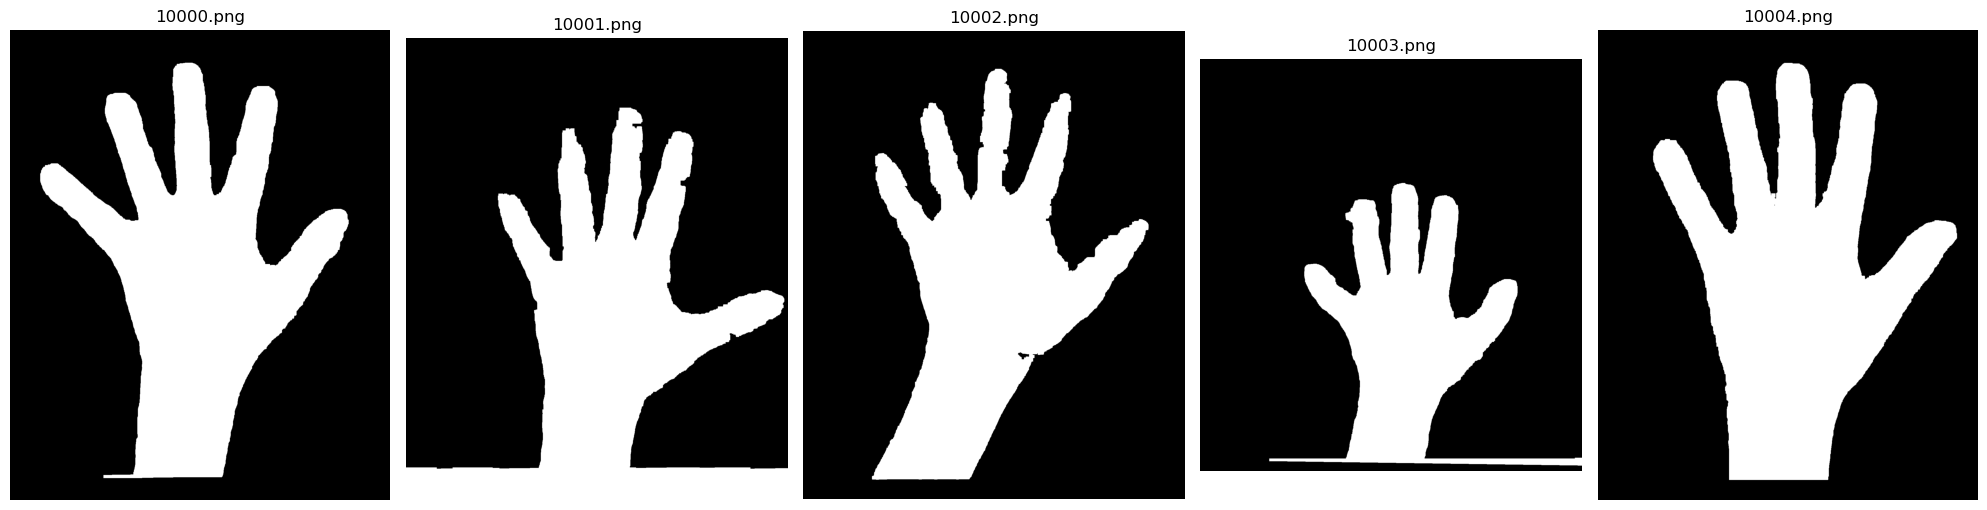

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\final project KHCC\finally binary images dilated"

# List of specific image filenames
image_names = ['10000.png', '10001.png', '10002.png', '10003.png', '10004.png']

display_specific_images_from_folder(folder_path, image_names)


Apply overlay to images

In [ ]:
import cv2
import numpy as np
import os

# Function to overlay binary masks on images, keeping only the regions that overlap with the mask
def overlay_masks_on_images(images_folder, masks_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # List all image files in the images folder
    image_files = [f for f in os.listdir(images_folder) if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
    
    for image_name in image_files:
        image_path = os.path.join(images_folder, image_name)
        mask_path = os.path.join(masks_folder, image_name)
        output_path = os.path.join(output_folder, image_name)
        
        # Load the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

        if image is None:
            print(f"Error: Image at path '{image_path}' could not be loaded.")
            continue
        if mask is None:
            print(f"Error: Mask at path '{mask_path}' could not be loaded.")
            continue

        # Ensure the mask is binary
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Apply the mask to the image, keeping only the overlapping regions
        masked_image = cv2.bitwise_and(image, image, mask=binary_mask)

        # Save the result
        cv2.imwrite(output_path, masked_image)
        print(f"Overlay result saved at: {output_path}")

    print("All images processed.")

# Set the folder paths
images_folder = r"C:\Users\LENOVO\Desktop\KHCC Photos\Wrist xray pngs\Wrist xray pngs"      # Replace with your images folder path
masks_folder = r"C:\Users\LENOVO\Desktop\KHCC Photos\Wrist xray pngs\Wrist dilated xray pngs"        # Replace with your masks folder path
output_folder = r"C:\Users\LENOVO\Desktop\KHCC Photos\Wrist xray pngs\Wrist xray overlay pngs"       # Replace with your output folder path

# Call the function to overlay masks on images
overlay_masks_on_images(images_folder, masks_folder, output_folder)


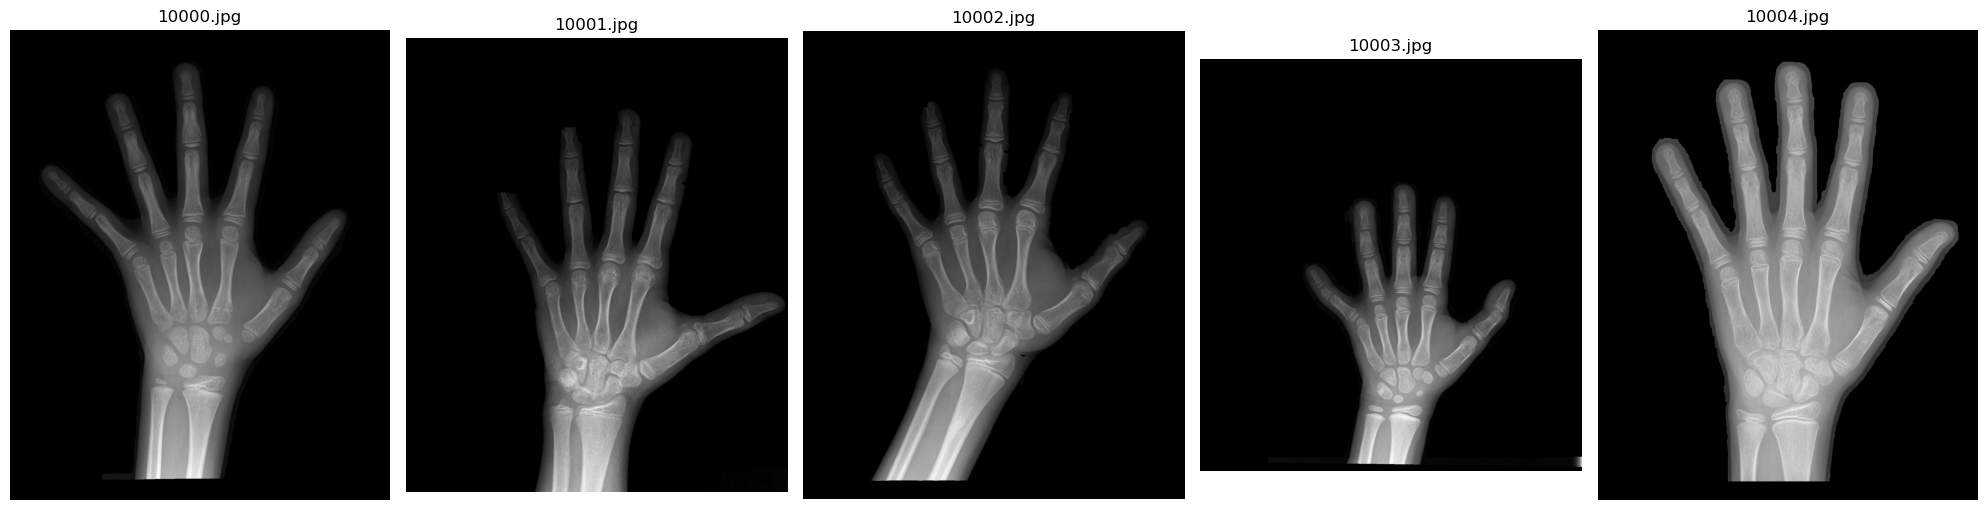

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\final project KHCC\finally overlay images jpg"

# List of specific image filenames
image_names = ['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']

display_specific_images_from_folder(folder_path, image_names)


Apply CLAHE to Images(Histogram Equalization)

In [ ]:
import cv2
import os

# Define the source and destination folder paths
source_folder = 'finally overlay images jpg'  # Replace with your source folder path
destination_folder = 'CLAHE'  # Replace with your destination folder path

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Apply CLAHE to each image in the source folder
for image_name in os.listdir(source_folder):
    image_path = os.path.join(source_folder, image_name)
    
    # Check if it's a valid image file
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Read the image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if the image is loaded properly
        if img is None:
            continue

        # Create a CLAHE object
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))

        # Apply CLAHE to the image
        clahe_img = clahe.apply(img)

        # Save the processed image to the destination folder
        output_image_path = os.path.join(destination_folder, image_name)
        cv2.imwrite(output_image_path, clahe_img)

print("CLAHE applied and images saved successfully.")


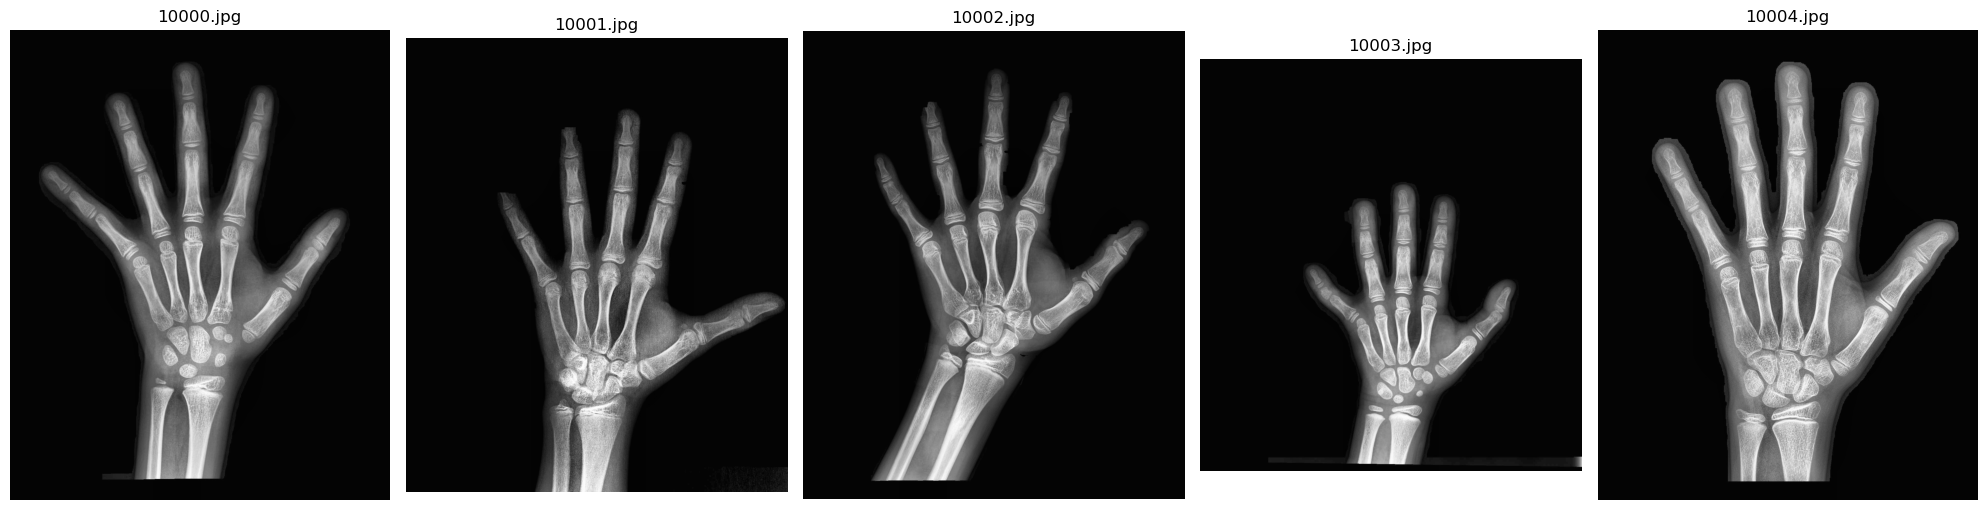

In [13]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\bone age prediction ViT\CLAHE"
# List of specific image filenames
image_names = ['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']

display_specific_images_from_folder(folder_path, image_names)


Apply Sharpening to Images

In [ ]:
import cv2
import os
import numpy as np

# Define the source and destination folder paths
source_folder = 'CLAHE'  # Replace with your source folder path
destination_folder = 'SHARPENING'  # Replace with your destination folder path


# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Apply Laplacian sharpening to each image in the source folder
for image_name in os.listdir(source_folder):
    image_path = os.path.join(source_folder, image_name)
    
    # Check if it's a valid image file
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Read the image
        img = cv2.imread(image_path)
        
        # Check if the image is loaded properly
        if img is None:
            continue
        
        # Convert the image to grayscale (Laplacian sharpening is usually done on grayscale images)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply the Laplacian filter
        laplacian = cv2.Laplacian(gray_img, cv2.CV_64F)

        # Sharpen the image by subtracting the Laplacian from the original image
        sharpened_img = np.uint8(np.clip(gray_img - laplacian, 0, 255))

        # Convert back to BGR (if you need color images)
        sharpened_bgr_img = cv2.cvtColor(sharpened_img, cv2.COLOR_GRAY2BGR)

        # Save the processed image to the destination folder
        output_image_path = os.path.join(destination_folder, image_name)
        cv2.imwrite(output_image_path, sharpened_bgr_img)

print("Laplacian sharpening applied and images saved successfully.")


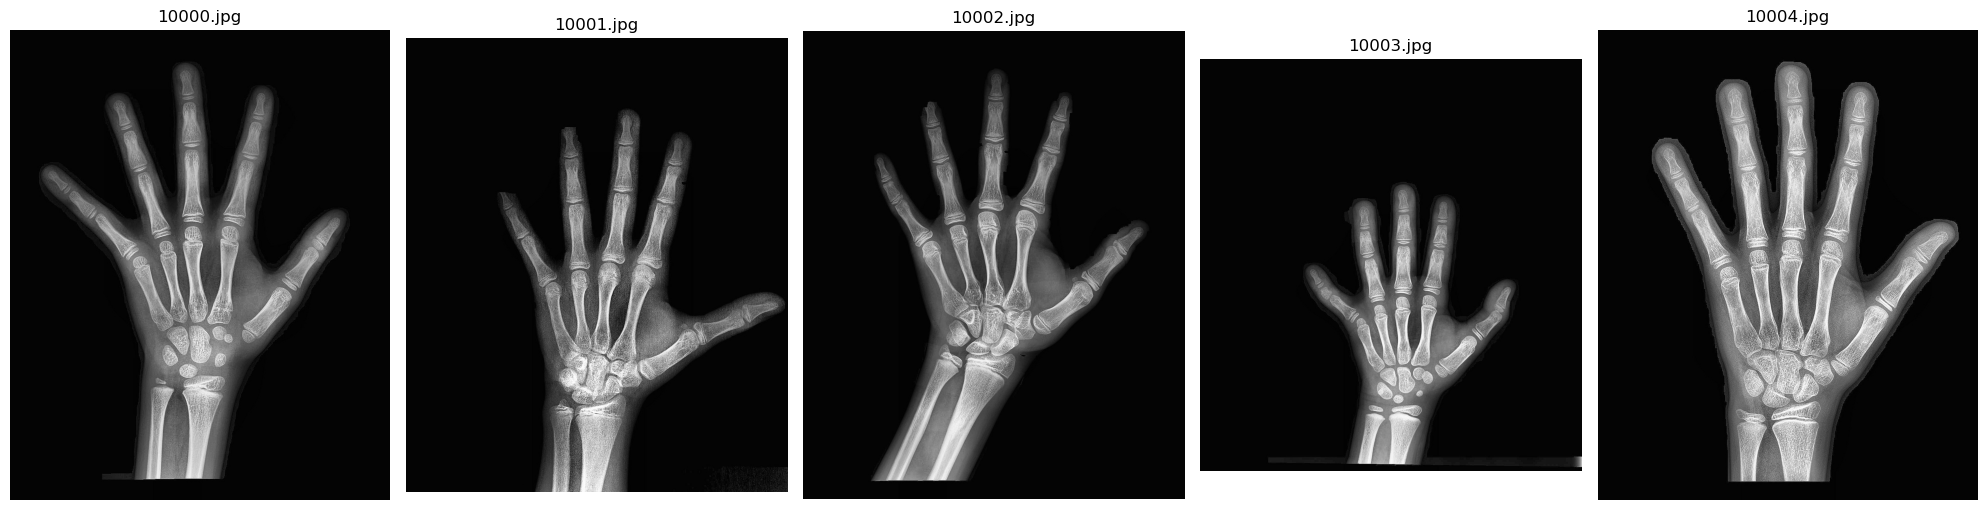

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = r"C:\Users\LENOVO\Desktop\bone age prediction ViT\SHARPENING"
# List of specific image filenames
image_names = ['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']

display_specific_images_from_folder(folder_path, image_names)


Now We Can Start The Project

In [2]:
import os
import pandas as pd

# Directories for images and CSV file
image_dir = r"C:\Users\LENOVO\Desktop\bone age prediction ViT\SHARPENING"
csv_file_path = r"C:\Users\LENOVO\Desktop\bone age prediction ViT\boneage-training-dataset - Copy.csv"

# Load the CSV file
age_df = pd.read_csv(csv_file_path)

# Map the 'id' column to the file paths of the corresponding images in the directory
age_df['path'] = age_df['id'].map(lambda x: os.path.join(image_dir, '{}.jpg'.format(x)))

# Check if the images exist in the directory
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')

# Map the 'male' column to a readable 'gender' format
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')

# Calculate the mean and standard deviation for bone age
boneage_mean = age_df['boneage'].mean()
boneage_div = 2 * age_df['boneage'].std()

# Disable normalization if desired
boneage_mean = 0
boneage_div = 1.0

# Create a 'boneage_zscore' column for normalized bone age values
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x - boneage_mean) / boneage_div)

# Drop any rows with missing values
age_df.dropna(inplace=True)

# Display a sample of the data
age_df.sample(3)



10121 images found of 10121 total


,id,boneage,male,path,exists,gender,boneage_zscore
9916,15373,156,True,C:\Users\LENOVO\Desktop\bone age prediction Vi...,True,male,156.0
3538,8022,132,False,C:\Users\LENOVO\Desktop\bone age prediction Vi...,True,female,132.0
2169,6440,138,True,C:\Users\LENOVO\Desktop\bone age prediction Vi...,True,male,138.0


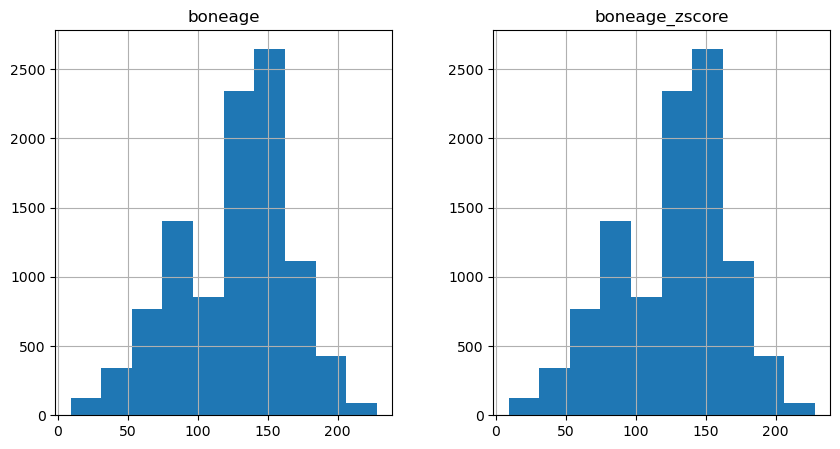

In [3]:
age_df[['boneage', 'male', 'boneage_zscore']].hist(figsize = (10, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 13)

In [4]:
len(age_df)

10121

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# First split: Separate test set (20% of total data)
train_valid_df, test_df = train_test_split(age_df,
                                          test_size=0.25,
                                          random_state=2018,
                                          stratify=age_df['boneage_category'])

2024-12-08 10:43:45.572688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 10:43:45.582668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733654625.594142     330 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733654625.597602     330 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 10:43:45.609493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

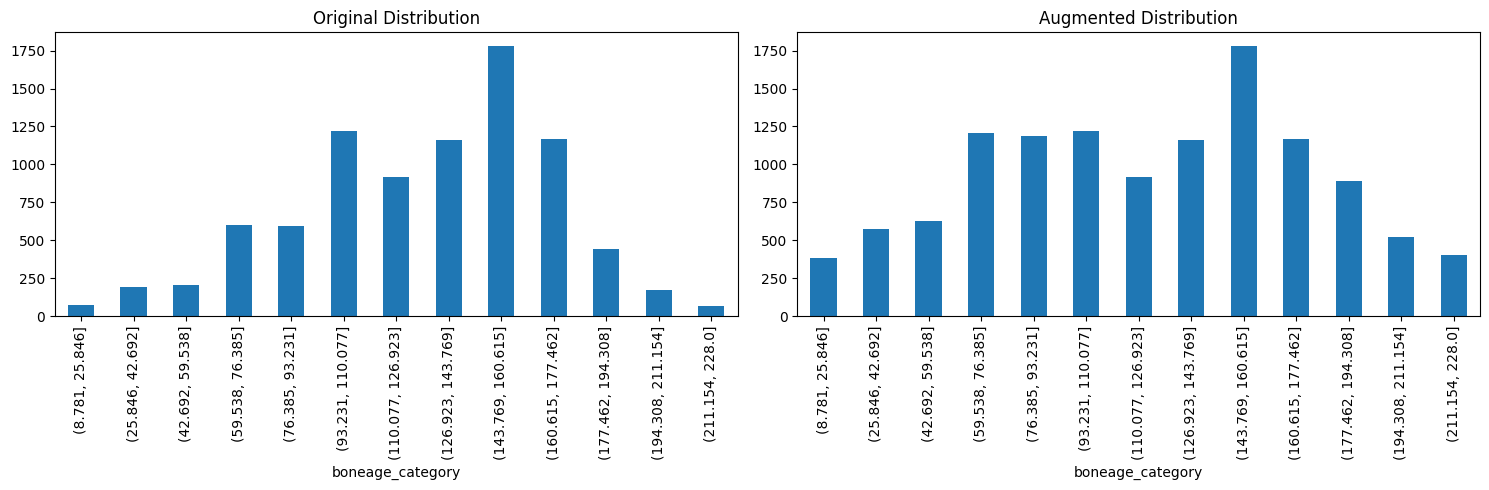

Epoch 8/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_1', 'input_layer_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 17.0893 - mean_absolute_error: 17.0893 - mean_squared_error: 489.2739
Epoch 8: val_loss improved from inf to 71.22224, saving model to best_model(All_Ages_ResNet34).keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1612s 5s/step - loss: 17.0856 - mean_absolute_error: 17.0856 - mean_squared_error: 489.0833 - val_loss: 71.2222 - val_mean_absolute_error: 71.2222 - val_mean_squared_error: 5955.9404 - learning_rate: 0.0010
Epoch 9/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 15.8967 - mean_absolute_error: 15.8967 - mean_squared_error: 414.9637
Epoch 9: val_loss did not improve from 71.22224
301/301 ━━━━━━━━━━━━━━━━━━━━ 1596s 5s/step - loss: 15.8955 - mean_absolute_error: 15.8955 - mean_squared_error: 414.9109 - val_loss: 79.7478 - val_mean_absolute_error: 79.7478 - val_mean_squared_error: 7527.2520 - learning_rate: 0.0010
Epoch 10/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 15.1392 - mean_absolute_error: 15.1392 - mean_squared_error: 384.5394


In [ ]:
#### import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
import os
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
class CustomModelSaver(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_every_n_epochs=15):
        super().__init__()
        self.filepath = filepath
        self.save_every_n_epochs = save_every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_every_n_epochs == 0:
            self.model.save(self.filepath.format(epoch=epoch+1))
            print(f"\nModel saved at epoch {epoch+1}")
# Custom Resize Function
def custom_resize(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

# Data Loading and Preprocessing Function
def load_and_preprocess_data(csv_path, image_folder, target_size=(384, 384), is_training=True):
    df = train_valid_df
    
    images = []
    boneages = []
    genders = []

    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, f"{row['id']}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = custom_resize(img, target_size)
            img_array = img.astype(np.float32) / 255.0
            images.append(img_array)
            
            if is_training:
                boneages.append(row['boneage'])
                genders.append(1 if row['male'] == True else 0)
    
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    
    if is_training:
        boneages = np.array(boneages)
        genders = np.array(genders)
        return images, boneages, genders
    else:
        return images, df['id'].values

# ResNet Blocks
def conv_block(input_tensor, filters, stride=1):
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    # Shortcut connection
    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, use_bias=False)(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor
    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# ResNet-34 Model Creation
def create_resnet34(image_input_shape, gender_input_shape):
    # Image input
    image_input = Input(shape=image_input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(image_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # ResNet-34 block configuration
    block_config = {
        64: 3,    # 3 blocks of 64 filters
        128: 4,   # 4 blocks of 128 filters
        256: 6,   # 6 blocks of 256 filters
        512: 3    # 3 blocks of 512 filters
    }
    
    # ResNet blocks
    first_block = True
    for filters, num_blocks in block_config.items():
        for block_idx in range(num_blocks):
            if block_idx == 0 and not first_block:
                x = conv_block(x, filters, stride=2)
            else:
                x = conv_block(x, filters, stride=1)
        first_block = False
    
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Gender input
    gender_input = Input(shape=gender_input_shape)
    
    # Concatenate image features with gender input
    x = layers.concatenate([x, gender_input])
    
    # Fully connected layers
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(2048, activation='relu')(x)
    # Output layer
    output = layers.Dense(1)(x)  # Single output for regression
    
    # Create the model
    model = Model(inputs=[image_input, gender_input], outputs=output)
    
    return model

# Weighted Augmentation Generator
class WeightedAugmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, boneages, genders, df, category_column, 
                 data_augmentation, batch_size=32, shuffle=True):
        self.images = images
        self.boneages = boneages
        self.genders = genders
        self.df = df
        self.category_column = category_column
        self.data_augmentation = data_augmentation
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Calculate category weights
        category_counts = df[category_column].value_counts()
        self.category_weights = 1 / category_counts
        self.category_weights = self.category_weights / self.category_weights.sum()
        
        # Create index mapping
        self.category_indices = {}
        for category in df[category_column].unique():
            self.category_indices[category] = df[df[category_column] == category].index
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.arange(len(self.images))
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.images))
        
        batch_indices = self.indices[start_idx:end_idx]
        
        batch_images = self.images[batch_indices]
        batch_boneages = self.boneages[batch_indices]
        batch_genders = self.genders[batch_indices]
        
        augmented_images = []
        for img in batch_images:
            aug_img = self.data_augmentation(tf.expand_dims(img, 0))
            augmented_images.append(tf.squeeze(aug_img, 0).numpy())
        
        return [np.array(augmented_images), batch_genders], batch_boneages
    
    def get_additional_augmentations(self):
        additional_images = []
        additional_boneages = []
        additional_genders = []
    
        for category, indices in self.category_indices.items():
            # Filter indices to only include those within the current image array bounds
            valid_indices = [idx for idx in indices if idx < len(self.images)]
        
            if not valid_indices:
                continue
        
            category_weight = self.category_weights.get(category, 1)
            num_extra_augs = int(np.round(category_weight * 18))
        
            category_images = self.images[valid_indices]
            category_boneages = self.boneages[valid_indices]
            category_genders = self.genders[valid_indices]
        
            for img, boneage, gender in zip(category_images, category_boneages, category_genders):
                for _ in range(num_extra_augs):
                    aug_img = self.data_augmentation(tf.expand_dims(img, 0))
                    additional_images.append(tf.squeeze(aug_img, 0).numpy())
                    additional_boneages.append(boneage)
                    additional_genders.append(gender)
    
        return (np.array(additional_images), 
                np.array(additional_boneages), 
                np.array(additional_genders))

# Visualization Function
def visualize_augmentation_distribution(original_boneages, augmented_boneages, category_column):
    original_df = pd.DataFrame({'boneage': original_boneages})
    original_df[category_column] = pd.cut(original_df['boneage'], 13)
    
    augmented_df = pd.DataFrame({'boneage': augmented_boneages})
    augmented_df[category_column] = pd.cut(augmented_df['boneage'], 13)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    original_df[category_column].value_counts().sort_index().plot(kind='bar', ax=ax1, title='Original Distribution')
    augmented_df[category_column].value_counts().sort_index().plot(kind='bar', ax=ax2, title='Augmented Distribution')
    
    plt.tight_layout()
    plt.show()

# Main Execution
def main():
    
    # Paths (replace with your actual paths)
    train_csv_path = "/kaggle/input/train-and-test2/boneage-training-dataset - Copy (2).csv"
    test_csv_path = "/kaggle/input/train-and-test2/boneage-test-dataset - Copy.csv"
    image_folder = "SHARPENING/SHARPENING/SHARPENING"
    
    # Load and preprocess training data
    train_images, train_boneages, train_genders = load_and_preprocess_data(
        train_csv_path, image_folder, target_size=(384, 384)
    )
    # Create DataFrame for category calculation
    age_df = pd.DataFrame({
        'boneage': train_boneages,
        'male': train_genders == 1
    })
    age_df['boneage_category'] = pd.cut(age_df['boneage'], 13)
    # Create DataFrame for category calculation
    #age_df = pd.read_csv(train_csv_path)
    #age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
    # Normalize the target variable (train_boneages or y_train)
    from sklearn.preprocessing import MinMaxScaler

    # Initialize the MinMaxScaler
    boneage_scaler = MinMaxScaler()

    # Apply Min-Max normalization to y_train (train_boneages)
    y_train_normalized = boneage_scaler.fit_transform(train_boneages.reshape(-1, 1))

    # Replace y_train with normalized values
    y_train = y_train_normalized
    # Data Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomZoom(0.1)
    ])
    
    # Prepare weighted augmentation generator
    train_generator = WeightedAugmentationGenerator(
        train_images, train_boneages, train_genders, 
        age_df, 'boneage_category', 
        data_augmentation, 
        batch_size=32  # Explicitly set batch size here
)
    
    # Get additional augmentations
    additional_images, additional_boneages, additional_genders = train_generator.get_additional_augmentations()
    
    # Combine original and additional augmented data
    X_train_combined = np.concatenate([train_images, additional_images])
    y_train_combined = np.concatenate([train_boneages, additional_boneages])
    gender_train_combined = np.concatenate([train_genders, additional_genders])
    
    # Split into training and validation sets
    X_train, X_val, y_train, y_val, gender_train, gender_val = train_test_split(
        X_train_combined, y_train_combined, gender_train_combined, 
        test_size=0.2, random_state=42
    )
    
    # Visualize augmentation distribution
    visualize_augmentation_distribution(train_boneages, y_train_combined, 'boneage_category')
    
    # Create model
    model = create_resnet34(
        image_input_shape=(384, 384, 1), 
        gender_input_shape=(1,)
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model(All_Ages_ResNet34).keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
        CustomModelSaver('model_epoch_with_more_neurons(All_Ages_ResNet34)_{epoch:04d}.keras', save_every_n_epochs=7)
    ]
    model = tf.keras.models.load_model('model_epoch_with_more_neurons(All_Ages_ResNet34)_0007.keras')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    # Train the model
    # Continue training from epoch 15
    history = model.fit(
    [data_augmentation(X_train), gender_train], 
    y_train,
    validation_data=([X_val, gender_val], y_val),
    epochs=100,  # This is now the total number of epochs you want to reach
    initial_epoch=7,  # Start from epoch 15
    batch_size=32,
    callbacks=callbacks
)
    # Load the model from epoch 15
    

"""
    
    # Load and preprocess test data
    test_images, test_ids = load_and_preprocess_data(
        test_csv_path, image_folder, 
        target_size=(384, 384), 
        is_training=False
    )
    
    # Inference with test data
    test_genders = np.ones((test_images.shape[0], 1))  # Replace with actual gender if available
    
    # Make predictions
    test_predictions = model.predict([test_images, test_genders])
    
    # Create results DataFrame
    test_results = pd.DataFrame({
        'id': test_ids,
        'predicted_boneage': test_predictions.flatten()
    })
    
    # Save results
    test_results.to_csv('/kaggle/working/bone_age_predictions.csv', index=False)
    
    print("Training completed and test predictions saved.")
"""
# Run the main function

if __name__ == "__main__":
    main()

In [8]:
#!pip install pandas
#!pip install scikit-learn
#!pip install opencv-python-headless
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import layers, models, Input, Model
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2

def custom_resize(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def load_and_preprocess_data(csv_path, image_folder, target_size=(384, 384), is_training=True):
    df = test_df
    
    images = []
    boneages = []
    genders = []

    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, f"{row['id']}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = custom_resize(img, target_size)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = img.astype(np.float32) / 255.0
            images.append(img_array)
            
            if is_training:
                boneages.append(row['boneage'])
                genders.append(1 if row['male'] == True else 0)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    
    if is_training:
        boneages = np.array(boneages)
        genders = np.array(genders)
        return images, boneages, genders
    else:
        return images, df['id'].values



# Load and preprocess test data
test_images, test_ids = load_and_preprocess_data(r"C:\Users\LENOVO\Downloads\testing_Resnet_34.csv", r"C:\Users\LENOVO\Desktop\bone age prediction ViT\SHARPENING", is_training=False)
testing = test_df
# You need to include the gender information during inference as well, this is just an example
# Assuming you have a default gender input (e.g., male = 1)
test_genders = testing["male"].astype(int).values  # Replace with actual gender information if available
#test_genders[:] = 1
test_genders = test_genders.flatten()
import tensorflow as tf
from tensorflow.keras.models import load_model
model2 = load_model(r"C:\Users\LENOVO\Downloads\best_model(All_Ages_ResNet34) (2).keras")
# Make predictions on test data
test_predictions = model2.predict([test_images,test_genders])

# Inverse transform the predictions to get original scale
#test_predictions_original = scaler.inverse_transform(test_predictions)

# Create a DataFrame with test results
test_results = pd.DataFrame({
    'id': test_ids,
    'predicted_boneage': test_predictions.flatten()
})

80/80 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step


In [9]:
len(test_df)

2531

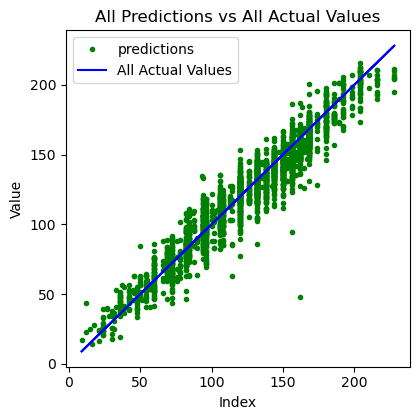

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming your arrays are already defined
# predictions_84_168, extracted_Y_84_168, predictions, extracted_Y

# Combine the prediction arrays
all_predictions = np.array(test_predictions).flatten()

# Combine the actual value arrays
all_actual = np.array(testing["boneage"]).flatten()

# Create indices for the x-axis
indices = np.arange(len(all_predictions))

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(4.3, 4.3))

# Plot all predictions as scatter points
ax.plot(all_actual, all_predictions, 'g.', label = 'predictions')

# Plot all actual values as a line
ax.plot(all_actual, all_actual, color='blue', label='All Actual Values')
#ax.grid(True)

# Set y-axis ticks to be in multiples of 10
#y_ticks = np.arange(0, max(np.max(all_predictions), np.max(all_actual)) + 10, 10)
#ax.set_yticks(y_ticks)
# Set title and labels
ax.set_title('All Predictions vs All Actual Values')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# Add legend
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [11]:
np.mean(np.abs((all_actual - (all_predictions))))

8.70032870293794

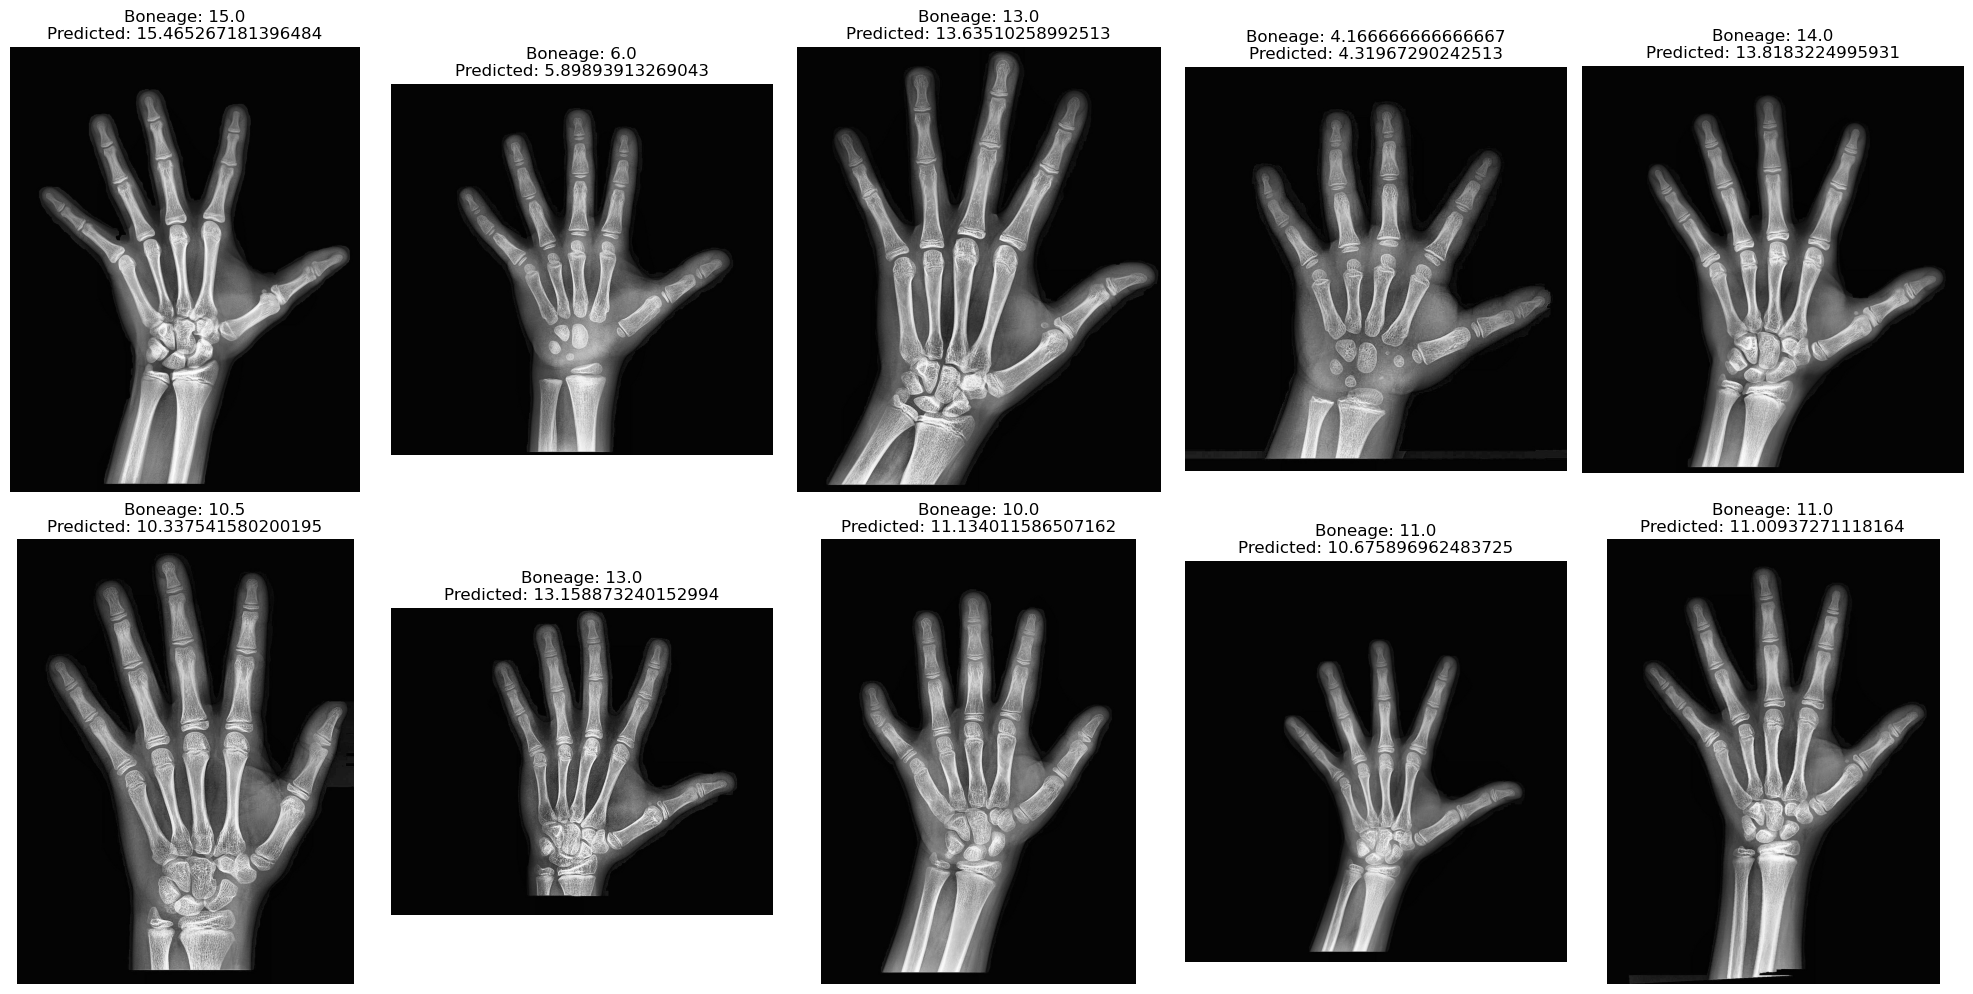

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

# Load the CSV file
csv_file = r"C:\Users\LENOVO\Downloads\archive\boneage-training-dataset.csv"  # Update with your actual CSV file path
data = pd.read_csv(csv_file)

# Folder containing the images
image_folder = r"C:\Users\LENOVO\Desktop\bone age prediction ViT\SHARPENING"  # Update with your actual folder path



# Create a DataFrame for the test IDs and predictions
test_data = pd.DataFrame({"id": test_ids, "predicted": all_predictions})

# Merge test_data with the CSV file to get the `boneage` column
merged_data = pd.merge(test_data, data, on="id")

# Select 10 random samples to visualize
sampled_data = merged_data.sample(n=10, random_state=42)

# Visualization
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, (idx, row) in enumerate(sampled_data.iterrows()):
    image_path = os.path.join(image_folder, f"{row['id']}.jpg")  # Update extension if necessary
    if os.path.exists(image_path):  # Ensure the image file exists
        image = Image.open(image_path)
        axes[i].imshow(image, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Boneage: {row['boneage']/12}\nPredicted: {row['predicted']/12}")
    else:
        axes[i].axis("off")
        axes[i].set_title(f"Image {row['id']} not found")

plt.tight_layout()
plt.show()


In [6]:
def custom_resize(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import io

class ImageProcessingGUI:
    def __init__(self, model, bone_age_model=None):
        """Initialize GUI with both segmentation and bone age models"""
        # Store both models
        self.model = model  # segmentation model
        self.bone_age_model = bone_age_model  # bone age model
        
        # Rest of the initialization code
        self.current_image = None
        self.original_image = None
        self.mask = None
        
        # Create file uploader
        self.file_uploader = widgets.FileUpload(
            accept='.jpg, .jpeg, .png',
            multiple=False,
            description='Upload Image'
        )
        
        # Create gender selector with a more visible style
        self.gender_selector = widgets.Dropdown(
            options=[('Male', 1), ('Female', 0)],
            value=1,
            description='Gender:',
            style={'description_width': 'initial'}
        )
        
        # Create buttons
        self.segment_button = widgets.Button(description='Segment Image')
        self.contour_button = widgets.Button(description='Apply Contours')
        self.dilate_button = widgets.Button(description='Dilate Image')
        self.overlay_button = widgets.Button(description='Overlay Image')
        self.clahe_button = widgets.Button(description='Apply CLAHE')
        self.sharpen_button = widgets.Button(description='Sharpen Image')
        self.bone_age_button = widgets.Button(
            description='Estimate Bone Age',
            style={'button_color': '#4CAF50'}  # Make the bone age button more visible
        )
        
        # Create output widget
        self.output = widgets.Output()
        
        # Add button callbacks
        self.file_uploader.observe(self.load_image, names='value')
        self.segment_button.on_click(self.segment_image)
        self.contour_button.on_click(self.apply_contours)
        self.dilate_button.on_click(self.dilate_image)
        self.overlay_button.on_click(self.overlay_image)
        self.clahe_button.on_click(self.apply_clahe)
        self.sharpen_button.on_click(self.sharpen_image)
        self.bone_age_button.on_click(self.estimate_bone_age)
        
        # Create layout
        self.create_layout()

    def predict_full_image(self, image, patch_size=128, stride=96):
        """Predict segmentation mask for the full image"""
        h, w = image.shape[:2]
        pred_mask = np.zeros((h, w))
        counts = np.zeros((h, w))
        
        for y in range(0, h-patch_size+1, stride):
            for x in range(0, w-patch_size+1, stride):
                patch = image[y:y+patch_size, x:x+patch_size]
                patch = patch.reshape((1, patch_size, patch_size, 1)) / 255.0
                pred = self.model.predict(patch)[0].reshape((patch_size, patch_size))
                
                pred_mask[y:y+patch_size, x:x+patch_size] += pred
                counts[y:y+patch_size, x:x+patch_size] += 1
        
        # Average overlapping predictions
        pred_mask = pred_mask / counts
        return pred_mask
    
    def create_layout(self):
        """Create and display the GUI layout with gender selector"""
        buttons = widgets.VBox([
            self.file_uploader,
            self.segment_button,
            self.contour_button,
            self.dilate_button,
            self.overlay_button,
            self.clahe_button,
            self.sharpen_button,
            self.gender_selector,
            self.bone_age_button
        ])
    
        layout = widgets.HBox([buttons, self.output])
        display(layout)
    
    def load_image(self, change):
        """Load the uploaded image"""
        with self.output:
            clear_output()
            if change['new']:
                # Get uploaded file data
                uploaded_file = next(iter(change['new']))
                image_data = change['new'][uploaded_file]['content']
                
                # Convert to numpy array
                image = Image.open(io.BytesIO(image_data))
                # Convert to grayscale
                image = image.convert('L')
                self.current_image = np.array(image)
                self.original_image = self.current_image.copy()
                
                # Display image
                plt.imshow(self.current_image, cmap='gray')
                plt.axis('off')
                plt.show()
    
    def segment_image(self, button):
        """Apply segmentation to the image"""
        with self.output:
            clear_output()
            if self.current_image is not None:
                # Apply segmentation
                self.mask = self.predict_full_image(self.current_image)
                
                # Display original and segmented images side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
                
                ax1.imshow(self.current_image, cmap='gray')
                ax1.set_title('Original Image')
                ax1.axis('off')
                
                ax2.imshow(self.mask, cmap='gray')
                ax2.set_title('Segmentation Mask')
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Store the mask as the current image
                self.current_image = (self.mask * 255).astype(np.uint8)
    
    def apply_contours(self, button):
        """Apply contours to the segmented mask and fill regions"""
        with self.output:
            clear_output()
            if self.current_image is not None:
            # Convert to uint8 if not already
                image = self.current_image.astype(np.uint8)
            
            # Apply binary threshold
                _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
            
            # Find contours
                contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Create a mask for filled regions
                filled_mask = np.zeros_like(binary_image)
            
            # Fill the contours with white
                cv2.fillPoly(filled_mask, contours, 255)
            
            # Create a 3-channel image for colored contours
                contour_image = cv2.cvtColor(filled_mask, cv2.COLOR_GRAY2BGR)
            
            
            # Convert back to RGB for matplotlib display
                contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
            
            # Display original and contoured images side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
                ax1.imshow(self.current_image, cmap='gray')
                ax1.set_title('Before Contours')
                ax1.axis('off')
            
                ax2.imshow(contour_image_rgb)
                ax2.set_title('After Contours (Filled)')
                ax2.axis('off')
            
                plt.tight_layout()
                plt.show()
            
            # Update current image
                self.current_image = cv2.cvtColor(contour_image, cv2.COLOR_BGR2GRAY)
    def dilate_image(self, button):
        """Apply dilation to the contoured image"""
        with self.output:
            clear_output()
            if self.current_image is not None:
            # Convert to uint8 if not already
                image = self.current_image.astype(np.uint8)
            
            # Apply binary threshold to get a binary image
                _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
            
            # Define the structuring element for dilation
                kernel = np.ones((11, 11), np.uint8)
            
            # Apply dilation
                dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
            
            # Display original and dilated images side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
                ax1.imshow(self.current_image, cmap='gray')
                ax1.set_title('Before Dilation')
                ax1.axis('off')
            
                ax2.imshow(dilated_image, cmap='gray')
                ax2.set_title('After Dilation')
                ax2.axis('off')
            
                plt.tight_layout()
                plt.show()
            
                # Update current image
                self.current_image = dilated_image
    
    def overlay_image(self, button):
        """Apply overlay using the original image and current processed mask"""
        with self.output:
            clear_output()
            if self.current_image is not None and self.original_image is not None:
                # Convert current image (mask) to binary
                _, binary_mask = cv2.threshold(self.current_image, 127, 255, cv2.THRESH_BINARY)
            
            # Convert original image to BGR if it's grayscale
                if len(self.original_image.shape) == 2:
                    original_bgr = cv2.cvtColor(self.original_image, cv2.COLOR_GRAY2BGR)
                else:
                    original_bgr = self.original_image.copy()
            
            # Apply the mask to the original image
                masked_image = cv2.bitwise_and(original_bgr, original_bgr, mask=binary_mask)
            
            # Display original, mask, and overlaid images
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            
            # Show original image
                if len(self.original_image.shape) == 2:
                    ax1.imshow(self.original_image, cmap='gray')
                else:
                    ax1.imshow(cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB))
                ax1.set_title('Original Image')
                ax1.axis('off')
            
                # Show current mask
                ax2.imshow(binary_mask, cmap='gray')
                ax2.set_title('Current Mask')
                ax2.axis('off')
            
                # Show overlay result
                ax3.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
                ax3.set_title('Overlay Result')
                ax3.axis('off')
            
                plt.tight_layout()
                plt.show()
            
                # Update current image to the overlay result
                self.current_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    
    def apply_clahe(self, button):
        """Apply CLAHE to the overlayed image and show before/after comparison"""
        with self.output:
            clear_output()
            if self.current_image is not None:
                # Store the image before CLAHE
                before_clahe = self.current_image.copy()
            
                # Apply CLAHE
                clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
                after_clahe = clahe.apply(self.current_image)
            
                # Display before and after images side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
                ax1.imshow(before_clahe, cmap='gray')
                ax1.set_title('Before CLAHE')
                ax1.axis('off')
            
                ax2.imshow(after_clahe, cmap='gray')
                ax2.set_title('After CLAHE')
                ax2.axis('off')
            
                plt.tight_layout()
                plt.show()
            
                # Update current image to the CLAHE result
                self.current_image = after_clahe
    
    def sharpen_image(self, button):
        """Apply Laplacian sharpening to the image and show before/after comparison"""
        with self.output:
            clear_output()
            if self.current_image is not None:
                # Store the image before sharpening
                before_sharp = self.current_image.copy()
            
                # Apply Laplacian sharpening
                laplacian = cv2.Laplacian(self.current_image, cv2.CV_64F)
                sharpened = np.uint8(np.clip(self.current_image - laplacian, 0, 255))
            
                # Display before and after images side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
                ax1.imshow(before_sharp, cmap='gray')
                ax1.set_title('Before Sharpening')
                ax1.axis('off')
            
                ax2.imshow(sharpened, cmap='gray')
                ax2.set_title('After Laplacian Sharpening')
                ax2.axis('off')
            
                plt.tight_layout()
                plt.show()
            
                # Update current image to the sharpened version
                self.current_image = sharpened
    
    def estimate_bone_age(self, button):
        """Apply bone age estimation model to the processed image"""
        with self.output:
            clear_output()
            if self.current_image is not None:
                try:
                    # Preprocess the image
                    img = self.current_image.copy()
                    
                    # Resize to match the model's expected input size
                    img = custom_resize(img, (384, 384))
                    
                    # Normalize
                    img = img.astype(np.float32) / 255.0
                    
                    # Add batch and channel dimensions
                    img = np.expand_dims(img, axis=0)  # Add batch dimension
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                    
                    # Get gender from selector
                    gender = np.array([self.gender_selector.value])
                    
                    # Create model inputs
                    model_input = {
                        'input_layer_1': img,
                        'input_layer_2': gender
                    }
                    
                    # Make prediction using the functional model
                    prediction = self.bone_age_model.predict(model_input)
                    predicted_age = prediction[0][0]
                    
                    # Display original image with prediction
                    fig, ax = plt.subplots(figsize=(8, 8))
                    
                    ax.imshow(self.current_image, cmap='gray')
                    ax.set_title(f'Predicted Bone Age: {predicted_age:.1f} months\n({predicted_age/12:.1f} years)')
                    ax.axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\nPredicted Bone Age: {predicted_age:.1f} months ({predicted_age/12:.1f} years)")
                    print(f"Gender: {'Male' if gender[0] == 1 else 'Female'}")
                    
                except Exception as e:
                    print(f"Error during bone age estimation: {str(e)}")
                    print("\nMake sure the bone age model is properly loaded and configured.")

from tensorflow.keras.models import load_model

# Load both models
model_segmentation = load_model(r"C:\Users\LENOVO\Downloads\hand_segmentation_patch_model.keras")
model_bone_age = load_model(r"C:\Users\LENOVO\Downloads\best_model(All_Ages_ResNet34) (2).keras")

# Create GUI instance with both models
gui = ImageProcessingGUI(model=model_segmentation, bone_age_model=model_bone_age)